In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
df = pd.read_csv('./dataset/no_date_set.csv')

In [3]:
df = df[df["zip_code_94107"]== 1]

In [4]:
TARGETS = df['trip_count'].to_numpy()

In [5]:
TRAIN_SPLIT = 800

In [6]:
tf.random.set_seed(13)

In [7]:
features_considered = ['trip_count',
        'isRain', 'isFog', 'isThunderstorm',
       'Weekday_Friday', 'Weekday_Monday', 'Weekday_Saturday',
       'Weekday_Sunday', 'Weekday_Thursday', 'Weekday_Tuesday',
       'Weekday_Wednesday', 'Holiday_Christmas Day', 'Holiday_Columbus Day',
       'Holiday_Independence Day', 'Holiday_Independence Day (Observed)',
       'Holiday_Labor Day', 'Holiday_Martin Luther King, Jr. Day',
       'Holiday_Memorial Day', "Holiday_New Year's Day", 'Holiday_None',
       'Holiday_Thanksgiving', 'Holiday_Veterans Day',
       "Holiday_Washington's Birthday"]

In [8]:
features = df[features_considered]

features.columns

Index(['trip_count', 'isRain', 'isFog', 'isThunderstorm', 'Weekday_Friday',
       'Weekday_Monday', 'Weekday_Saturday', 'Weekday_Sunday',
       'Weekday_Thursday', 'Weekday_Tuesday', 'Weekday_Wednesday',
       'Holiday_Christmas Day', 'Holiday_Columbus Day',
       'Holiday_Independence Day', 'Holiday_Independence Day (Observed)',
       'Holiday_Labor Day', 'Holiday_Martin Luther King, Jr. Day',
       'Holiday_Memorial Day', 'Holiday_New Year's Day', 'Holiday_None',
       'Holiday_Thanksgiving', 'Holiday_Veterans Day',
       'Holiday_Washington's Birthday'],
      dtype='object')

In [9]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [10]:
dataset = (dataset-data_mean)/data_std

In [11]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [12]:
past_history = 60
STEP = 1
BUFFER_SIZE = 2000
BATCH_SIZE = 64
LABEL_IDX = 0

In [13]:
single_var_df = dataset[:,LABEL_IDX].reshape(-1,1)

In [14]:
future_target = 14
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:,LABEL_IDX], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:,LABEL_IDX],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

Let's check out a sample data-point.

In [15]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (60, 23)

 Target temperature to predict : (14,)


In [16]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [21]:
def create_time_steps(length):
    time_steps = []
    for i in range(-length, 0, 1):
        time_steps.append(i)
    return time_steps

In [40]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 0]), label='History')
    plt.plot(np.arange(num_out), np.array(true_future), label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out), np.array(prediction), 'r-', label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

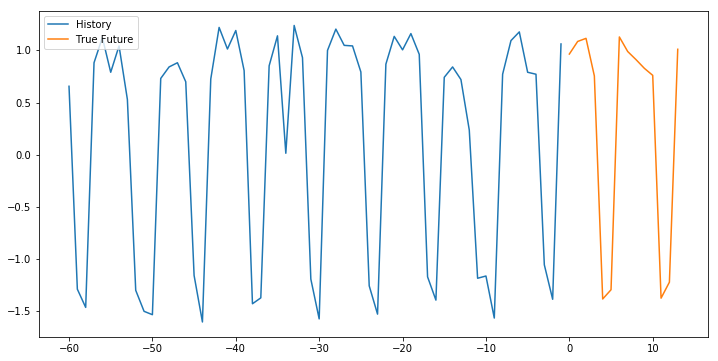

In [41]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

In [127]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(64,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(32, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(future_target))
multi_step_model.add(tf.keras.layers.Dense(future_target))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')
#multi_step_model.compile(optimizer=tf.keras.optimizers.Adam(clipvalue=1.0), loss='mae')

In [128]:
EVALUATION_INTERVAL = 200
EPOCHS = 8

In [129]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/8
200/200 [==============================] - 16s 80ms/step - loss: 0.6007 - val_loss: 0.4129
Epoch 2/8
200/200 [==============================] - 14s 68ms/step - loss: 0.3126 - val_loss: 0.3353
Epoch 3/8
200/200 [==============================] - 14s 69ms/step - loss: 0.2490 - val_loss: 0.3911
Epoch 4/8
200/200 [==============================] - 14s 69ms/step - loss: 0.2251 - val_loss: 0.3514
Epoch 5/8
200/200 [==============================] - 14s 68ms/step - loss: 0.2070 - val_loss: 0.3584
Epoch 6/8
200/200 [==============================] - 14s 68ms/step - loss: 0.1955 - val_loss: 0.3896
Epoch 7/8
200/200 [==============================] - 14s 68ms/step - loss: 0.1874 - val_loss: 0.3895
Epoch 8/8
200/200 [==============================] - 14s 69ms/step - loss: 0.1812 - val_loss: 0.3586


In [116]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

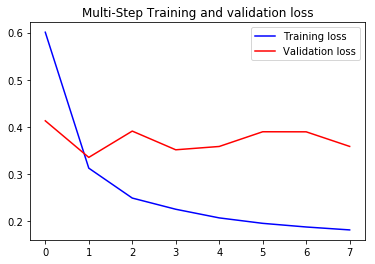

In [130]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

#### Predict a multi-step future
Let's now have a look at how well your network has learnt to predict the future.

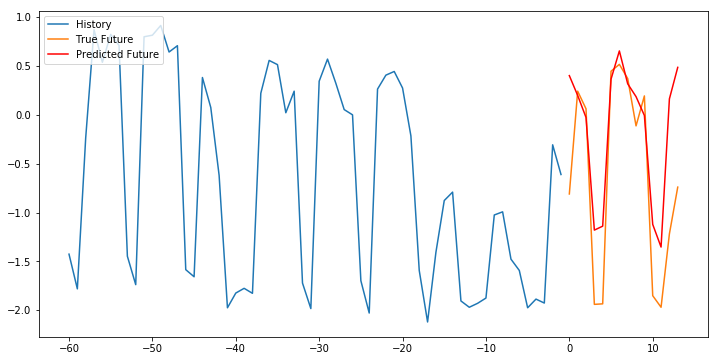

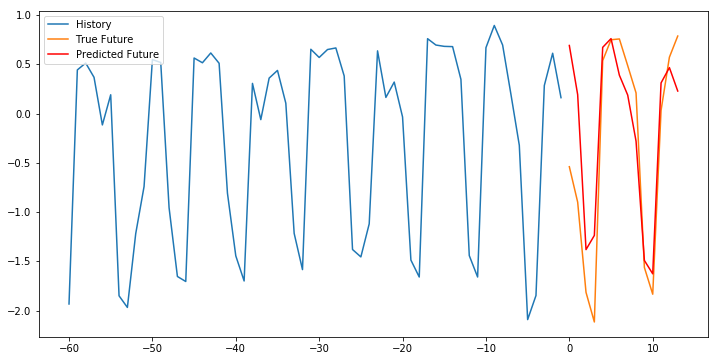

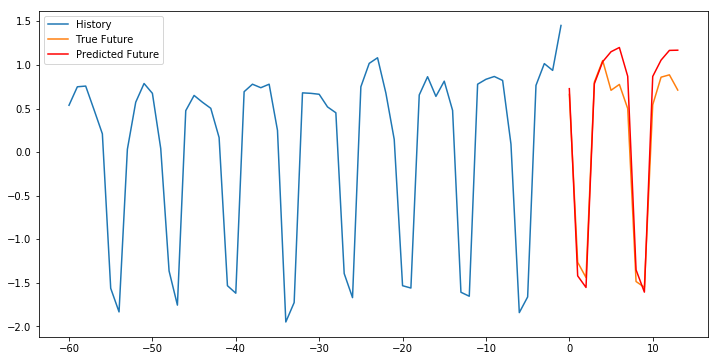

In [131]:
for x, y in val_data_multi.take(3):
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

In [132]:
multi_step_model.save('LSTM-64-32-2FC-RMSProp-NC.h5')